# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

Импортируем необходимые для работы библиотеки и инструменты:

In [203]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats as st
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings('ignore') # команда-блокиратор предупреждений

Загрузим данные геологоразведки 3 регионов:

In [204]:
geo_data_0 = pd.read_csv('/datasets/geo_data_0.csv')
geo_data_1 = pd.read_csv('/datasets/geo_data_1.csv')
geo_data_2 = pd.read_csv('/datasets/geo_data_2.csv')

geo_datas = [geo_data_0, geo_data_1, geo_data_2]

Ознакомимся с данными, реализовав их отображение по каждому региону через цикл, проверим на наличие явных дубликатов:

In [249]:
i = 0 # не сообразил, как иначе отобразить номера регионов
for geo_data in geo_datas:
    print("Данные по региону №", i)
    display(geo_data.sample(3))
    print()
    print(geo_data.info())
    print()
    print("Количество явных дубликатов - ", geo_data.duplicated().sum())
    print()
    i += 1
    

Данные по региону № 0


,f0,f1,f2,product
96082,-0.700479,0.718521,4.600402,12.691786
540,0.767502,0.338975,1.466431,53.347895
2950,0.004139,0.163906,1.166076,90.585242



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   f0       100000 non-null  float64
 1   f1       100000 non-null  float64
 2   f2       100000 non-null  float64
 3   product  100000 non-null  float64
dtypes: float64(4)
memory usage: 3.1 MB
None

Количество явных дубликатов -  0

Данные по региону № 1


,f0,f1,f2,product
80729,-6.572730,-3.547452,3.003460,84.038886
5431,-2.938610,-13.501969,-0.008559,3.179103
52298,0.183903,-3.256391,4.000043,110.992147



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   f0       100000 non-null  float64
 1   f1       100000 non-null  float64
 2   f2       100000 non-null  float64
 3   product  100000 non-null  float64
dtypes: float64(4)
memory usage: 3.1 MB
None

Количество явных дубликатов -  0

Данные по региону № 2


,f0,f1,f2,product
93882,0.138717,1.189609,3.770182,108.580920
13322,0.257655,3.496048,2.935295,136.390869
18992,0.410254,0.441268,-0.564473,32.949365



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   f0       100000 non-null  float64
 1   f1       100000 non-null  float64
 2   f2       100000 non-null  float64
 3   product  100000 non-null  float64
dtypes: float64(4)
memory usage: 3.1 MB
None

Количество явных дубликатов -  0



- Пропущенных значений в данных нет, явных дубликатов тоже нет;
- Столбец с id не несет полезной для нас информации, для решения нашей задачи данные этого столбца не потребуются, удалим этот столбец из всех трех таблиц:


In [206]:
for geo_data in geo_datas:
    geo_data.drop('id', axis='columns', inplace=True)

- Нам неизвестно, что означают признаки точек f0, f1, f2, проверим факторы на мультиколлинеарность через корреляцию:

Таблица корреляции для данных региона 0

          product        f0        f1        f2
product  1.000000  0.143536 -0.192356  0.483663
f0       0.143536  1.000000 -0.440723 -0.003153
f1      -0.192356 -0.440723  1.000000  0.001724
f2       0.483663 -0.003153  0.001724  1.000000

Матрица корреляции для данных региона 0



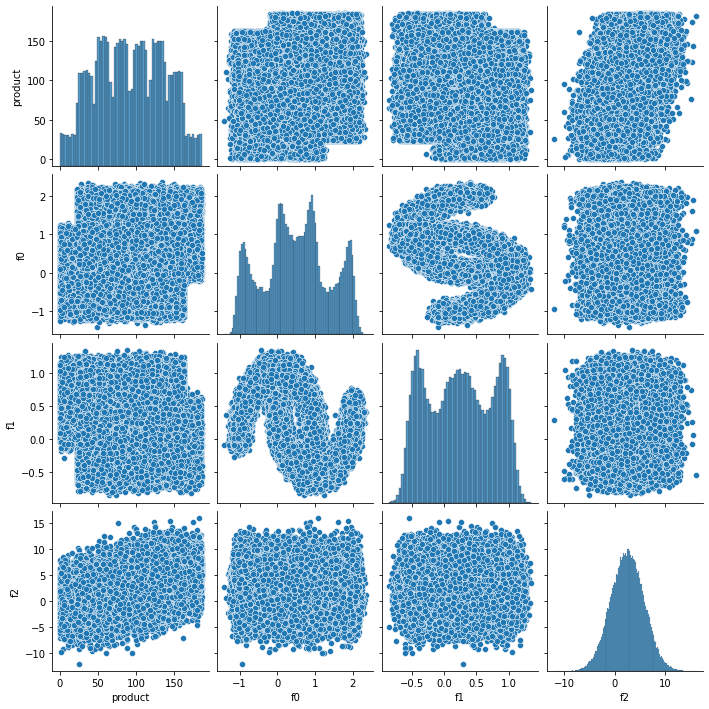

Таблица корреляции для данных региона 1

          product        f0        f1        f2
product  1.000000 -0.030491 -0.010155  0.999397
f0      -0.030491  1.000000  0.182287 -0.001777
f1      -0.010155  0.182287  1.000000 -0.002595
f2       0.999397 -0.001777 -0.002595  1.000000

Матрица корреляции для данных региона 1



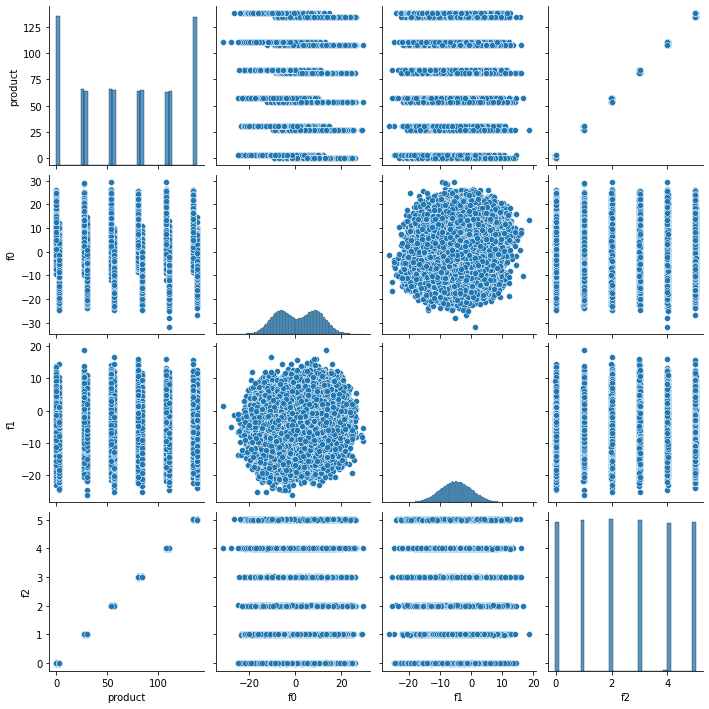

Таблица корреляции для данных региона 2

          product        f0        f1        f2
product  1.000000 -0.001987 -0.001012  0.445871
f0      -0.001987  1.000000  0.000528 -0.000448
f1      -0.001012  0.000528  1.000000  0.000779
f2       0.445871 -0.000448  0.000779  1.000000

Матрица корреляции для данных региона 2



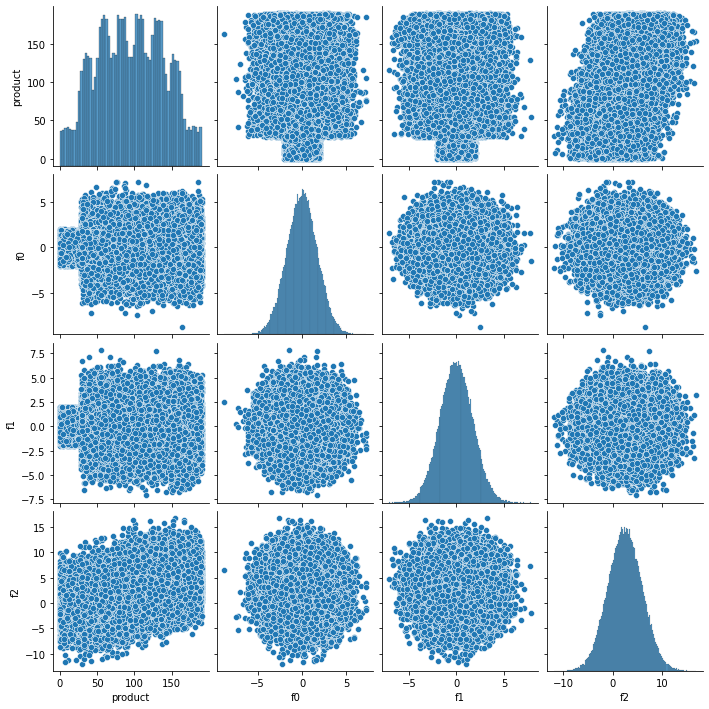

In [207]:
i = 0
for geo_data in geo_datas:
    print("Таблица корреляции для данных региона", i)
    print()
    print(geo_data[['product', 'f0', 'f1', 'f2']].corr())
    print()
    print("Матрица корреляции для данных региона", i)
    print()
    print(sns.pairplot(geo_data[['product', 'f0', 'f1', 'f2']]))
    plt.show()
    i +=1

Для регионов 0 и 2 показатели корреляции данных не имеют аномалий, сильной зависимости нет, больше всего влияниие на целевой признак оказывает параметр f2.

А вот в регионе 1 по данным корреляции факторов видим странное распределение значений по всем признакам и аномальную зависимость целевого признака от параметра f2. Можно этот столбец исключить из дальнейшей работы, но т.к. мы не знаем, что обозначает этот признак, а в условии задачи указано, что все признаки значимы, то оставим этот столбец без изменений.

Изучим данные столбца product по регионам: 

In [208]:
for geo_data in geo_datas:
    print(len(geo_data['product'].unique()))

100000
12
100000


Количество уникальных значений в столбце product в данных по региону 1 всего 12, что очень странно, изучим эти значения:

In [209]:
print(geo_data_1['product'].value_counts())
print()
products_1 = pd.Series(geo_data_1['product'].sort_values().unique())
print(products_1)  

53.906522     8472
26.953261     8468
84.038886     8431
57.085625     8390
3.179103      8337
80.859783     8320
30.132364     8306
134.766305    8304
110.992147    8303
0.000000      8235
137.945408    8233
107.813044    8201
Name: product, dtype: int64

0       0.000000
1       3.179103
2      26.953261
3      30.132364
4      53.906522
5      57.085625
6      80.859783
7      84.038886
8     107.813044
9     110.992147
10    134.766305
11    137.945408
dtype: float64


Значения распределены примерно равномерно, причем прослеживается некая прогрессия в увеличении данных:

In [210]:
i = 0
while i < (len(products_1)-1):
    print(f"{products_1[i+1] - products_1[i]:.2f}")
    i += 1

3.18
23.77
3.18
23.77
3.18
23.77
3.18
23.77
3.18
23.77
3.18


Итог по данным из региона 1:
- странное распределение значений в матрице корреляции 
- значения столбцов f2 и product мультиколлинеарны
- значения в столбце product имеют всего 12 уникальных значений
- значения столбца product равномерно распределены
- между этими значениями прослеживается четкая зависимость (арифметическая прогрессия)

Можно сделать вывод, что данные по региону 1 были внесены искусственно опираясь на значения из столбца f2. В реальном проекте следовало бы уточнить, как были получены данные по региону 1 и исходя из нашего вывода ставить вопрос о целесообразности проведения исследования по данному региону.

Поскольку проект учебный, оставим все как есть и приступим к следующему пункту.

## Обучение и проверка модели

Для обучения модели используем линейную регрессию. Создадим функцию **get_prediction**, которая получает на вход данные по региону, разбивает на тестовую и валидационную выборки в соотношении 75:25, обучает модель на тестовой выборке и делает предсказания на валидационной, рассчитывает значение MSE:

In [211]:
def get_prediction (geo_data):
    target = geo_data['product']
    features = geo_data.drop(['product'], axis=1)
    features_train, features_valid, target_train, target_valid = train_test_split(features, target,
                                                                                  test_size=.25,
                                                                                  random_state=12345)
    model = LinearRegression()
    model.fit(features_train, target_train)
    predicted_valid = pd.Series(model.predict(features_valid))
    mse = mean_squared_error(target_valid, predicted_valid)
    
    return predicted_valid, target_valid, mse

Сохраним результаты на валидационной выборке в соответствующих переменных:

In [212]:
predicted_valid_0, target_valid_0, mse_0 = get_prediction(geo_data_0)
predicted_valid_1, target_valid_1, mse_1 = get_prediction(geo_data_1)
predicted_valid_2, target_valid_2, mse_2 = get_prediction(geo_data_2)

Напечатаем на экране средний запас предсказанного сырья и RMSE модели:

In [213]:
predictions = [predicted_valid_0, predicted_valid_1, predicted_valid_2]
mse_list = [mse_0, mse_1, mse_2]
i = 0
for predicted in predictions:
    print("Данные по региону", i)
    print(f"Средний запас предсказанного сырья ~ {predicted.mean():.3f} тыс. баррелей")
    print(f"Значение RMSE модели ~ {mse_list[i] ** 0.5:.3f}")
    print()
    i += 1

Данные по региону 0
Средний запас предсказанного сырья ~ 92.593 тыс. баррелей
Значение RMSE модели ~ 37.579

Данные по региону 1
Средний запас предсказанного сырья ~ 68.729 тыс. баррелей
Значение RMSE модели ~ 0.893

Данные по региону 2
Средний запас предсказанного сырья ~ 94.965 тыс. баррелей
Значение RMSE модели ~ 40.030



**Вывод:** 
- Лучший показатель RMSE модели получился по данным региона 1, причем с огромным отрывом от других. Связано это с искусственной природой появления этих данных, о чем мы описывали в первом пункте проекта
- Сравнивая 0 и 2 регионы, то показатель RMSE немного лучше у региона под номером 0
- По предсказанному среднему запасу сырья ситуация обратная - худший показатель у региона 1 (с отрывом), среди оставшихся регионов немного больший запас предсказано в регионе 2

Резюмируя, на правдоподобных данных по регионам 0 и 2 модель отработала явно хуже, вероятность и величина ошибки в результатах предсказаний заметно выше. Возможно из-за этого предсказанные средние запасы сырья в этих регионах значительно больше, чем в предсказано по искусственным данным для региона 1.

## Подготовка к расчёту прибыли

Сохраним указанные в условии задачи ключевые значения для расчетов в отдельных переменных:

In [214]:
# бюджет на разработку скважин в одном регионе в рублях
budget = 10e9

# количество скважин для бурения
number_of_wells = 200

# доход с одной единицы продукта в рублях
income_per_unit = 450e3

# максимальная доля убытков
max_risk = 0.025

# бюджет на разработку одной скважины
budget_per_well = budget / number_of_wells

Рассчитаем достаточный объём сырья для безубыточной разработки новой скважины и средний запас в каждом регионе:

In [215]:
print(f"Достаточный объем сырья для безубыточной разработки одной скважины ~ {budget_per_well / income_per_unit:.3f} тыс. баррелей")

Достаточный объем сырья для безубыточной разработки одной скважины ~ 111.111 тыс. баррелей


Сравним со средним запасом сырья в каждом регионе:

In [216]:
i = 0
for geo_data in geo_datas:
    print("Данные по региону", i)
    print(f"Средний запас сырья ~ {geo_data['product'].mean():.3f} тыс. баррелей")
    print()
    i += 1

Данные по региону 0
Средний запас сырья ~ 92.500 тыс. баррелей

Данные по региону 1
Средний запас сырья ~ 68.825 тыс. баррелей

Данные по региону 2
Средний запас сырья ~ 95.000 тыс. баррелей



**ВЫВОД:**
- Среднее значение запасов сырья во всех регионах меньше, чем минимально требуемое значение для безубыточной разработки. Большая часть скважин во всех регионах не имеет достаточного запаса сырья. Для реализации прибыльной разработки скважин следует тщательно отобрать 200 скважин, запас сырья в которых максимальный из представленных.  

## Расчёт прибыли и рисков 

Напишем функцию для расчёта прибыли, которая выберет скважины с максимальным значением, просуммирует объем сырья, соответствующее предсказаниям и рассчитает прибыль:

In [217]:
def revenue(target, predicted):
    target = pd.Series(target).reset_index(drop=True)
    predicted_sort = pd.Series(predicted).reset_index(drop=True).sort_values(ascending=False)
    selected = target[predicted_sort.index][:number_of_wells]
    return ((income_per_unit * selected.sum()) - budget) 

In [250]:
targets = [target_valid_0, target_valid_1, target_valid_2]
predictions = [predicted_valid_0, predicted_valid_1, predicted_valid_2]
i = 0
while i < 3:
    print("Данные по региону", i)
    print(f"Расчетная рибыль для полученного объема сырья ~ {revenue(targets[i], predictions[i]) / 1e9:.3f} млрд. руб.")
    print()
    i += 1

Данные по региону 0
Расчетная рибыль для полученного объема сырья ~ 3.321 млрд. руб.

Данные по региону 1
Расчетная рибыль для полученного объема сырья ~ 2.415 млрд. руб.

Данные по региону 2
Расчетная рибыль для полученного объема сырья ~ 2.710 млрд. руб.



Посчитаем риски и прибыль для всех трех регионов с помощью процедуры Bootstrap:

In [251]:
state = np.random.RandomState(12345)
def bootstrap (target, predicted):
    values = []
    for i in range(1000):
        target_subsample = target.reset_index(drop=True).sample(n=500, replace=True, random_state=state)
        predicted_subsample = predicted[target_subsample.index]
        rev = revenue(target_subsample, predicted_subsample)
        values.append(rev)

    values = pd.Series(values)
    lower = values.quantile(0.025) / 10e9
    upper = values.quantile(0.975) / 10e9
        
    print(f"Средняя прибыль ~ {values.mean() / 1e9:.3f} млрд. руб.")
    print(f"Доверительный интервал ({lower:.3f} млрд. руб. , {upper:.3f} млрд. руб.)")
    print(f"Риски убытка {(values < 0).mean()*100:.1f} %")

In [252]:
i = 0
while i < 3:
    print("Данные по региону", i)
    bootstrap(targets[i], predictions[i])
    print()
    i += 1

Данные по региону 0
Средняя прибыль ~ 0.396 млрд. руб.
Доверительный интервал (-0.011 млрд. руб. , 0.091 млрд. руб.)
Риски убытка 6.9 %

Данные по региону 1
Средняя прибыль ~ 0.461 млрд. руб.
Доверительный интервал (0.008 млрд. руб. , 0.086 млрд. руб.)
Риски убытка 0.7 %

Данные по региону 2
Средняя прибыль ~ 0.393 млрд. руб.
Доверительный интервал (-0.011 млрд. руб. , 0.093 млрд. руб.)
Риски убытка 6.5 %



**ВЫВОД:** 

Исходя из полученных значений наиболее выгодным и безопасным регионом для разработки является регион 1: риск убытка здесь около 0,7%, что ниже указанных в условии 2,5%, расчетная средняя прибыль выше, чем у других регионов. 

Если отбросить условие, что данные по региону 1 искусственные, то однозначно нужно делать выбор в пользу этого региона. Оставшиеся регионы 0 и 2 имеют относительно равные параметры риска и потенциальной прибыли, выбрать один из них затруднительно.